Proximal Policy Method

Refresh about Actor-Critic Algorithm
For detailed instruction, visited: https://www.neuralnet.ai/a-crash-course-in-proximal-policy-optimization/
1. Actor: π ( a ∣ s ) is the probability off taking action a in state s. Maximize the expected return by choosing a good policy
2. Critic: V(s) estimates the expected cummulative reward stating from state s.
All are modelled by a network
3. Advantage function: A(s, a) = Q(s, a) - V(s). We WANT TO MAXIMIZE THIS.
Difference between return and cummulative reward
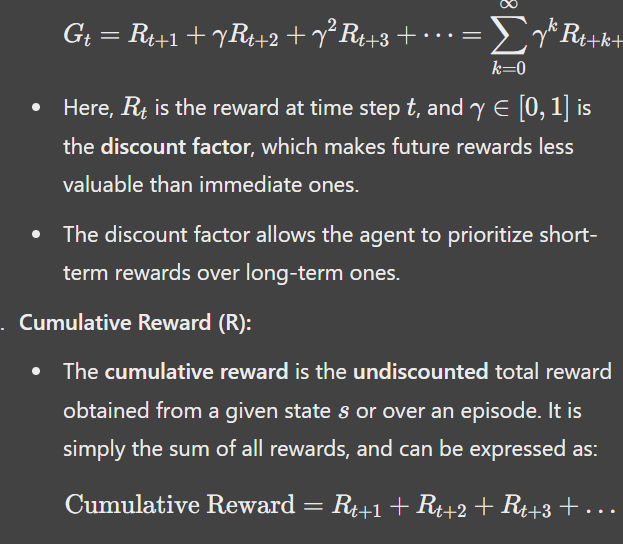

4. Advantage at each time step: 
5. Objective function L_CPI(param):
Note that r_t(param) tells us how much policy has changed. E_t represents the expected value at time step t
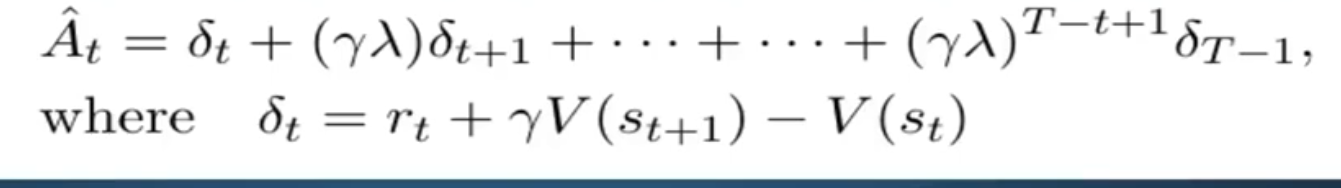
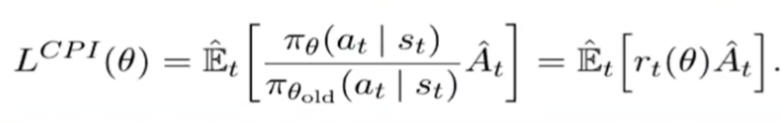

PPO vs DQN:
1. DQN works well with discrete action spaces. PPO works well with both discreate and continuous action space
2. 

In [3]:
import os
import torch as t
import torch.nn as nn
import torch.optim as optim
import gym   
import torch.distributions as D
import random
import numpy as np

In [4]:
class PPO: #this class is created to store all information such as state, action, probability of action, value, reward into a list
    def __init__(self, batch_size): #batch_size of memories;
        self.states = []
        self.actions = []
        self.rewards = []
        self.done = []
        self.probs = []
        self.vals = []
        self.batch_size = batch_size
    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size) # 0, 5, 10, 115
        indicies = np.arange(n_states)
        np.random.shuffle(indicies) #now list in indicies is shuffled #2, 1, 3, 5, 7, 9
        batches = [indicies[i:i + self.batch_size] for i in batch_start]
        return np.array(self.states), np.array(self.actions), np.array(self.probs), np.array(self.vals),\
            np.array(self.rewards), np.array(self.done), batches
        
    def store(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.done.append(done)
    
    def clear_memory(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.done = []
        self.probs = []
        self.vals = []

In [5]:

class ActorNetwork(nn.Module): #pass a state with a number of actions
    def __init__(self, n_actions: int, input_dims: int, alpha: float, fc1_dims = 128, fc2_dims = 128):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, n_actions), 
            nn.Softmax(dim = -1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr = alpha)
    def forward(self, state):
        dist = self.actor(state)
        dist = D.Categorical(dist)
        return dist #return a distribution of 
class CriticNetwork(nn.Module): #pass a state with a number of actions
    def __init__(self, n_actions: int, input_dims: int,alpha: float, fc1_dims = 128, fc2_dims = 128):
        super().__init__()
        self.critic = nn.Sequential(
            nn.Linear(input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, 1), 
        )
        self.optimizer = optim.Adam(self.parameters(), lr = alpha)
    def forward(self, state):
        value = self.critic(state) 
        return value             

In [11]:
class Agent:
    def __init__(self, n_actions, input_dims:int, gamma: float, alpha: float, gae_lambda: float, policy_clip: float, batch_size = 5, n_epochs = 10):
        self.n_actions = n_actions
        self.critic = CriticNetwork(n_actions, input_dims, alpha) #return the estimated V(s)
        self.actor = ActorNetwork(n_actions, input_dims, alpha) #return a distribution of n_actions
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.memory = PPO(batch_size)
        
        self.gamma = gamma
        self.alpha = alpha
        self.gae_lambda = gae_lambda
    
    def remember(self, state, action, probs, vals, reward, done): #after each time step, we receive the things as listed, we need to append them to arrays
         self.memory.store(state, action, probs, vals, reward, done)  
          
    def choose_action(self, state): #choose the action with highest probability in ActorNetwork
        state = t.tensor(state)
        action_dist = self.actor.forward(state)
        value  = self.critic.forward(state) #float
        action = action_dist.sample()
        prob = action_dist.log_prob(action).item()
        action = t.squeeze(action).item()
        value = t.squeeze(value).item()
        return int(action), prob, value

    def learn(self): #define the advantage function at time step t here
        for epoch in range(self.n_epochs):
            state_arr, action_arr, old_probs_arr, vals_arr, reward_arr, done_arr, batches = self.memory.generate_batches() #when doing this we've already have a samples of 20
            advantages = np.zeros(len(reward_arr), dtype = np.float32) #(batch_size, )
            batch_size = len(batches)
            for i in range(batch_size - 1): #calculate all advantage from current batch_size
                for j in range(i, len(reward_arr) - 1):
                    delta_t = reward_arr[j] + self.gamma * vals_arr[j+1]*(1-int(done_arr[j])) - vals_arr[j]
                    #Remember we use 1-int(done_arr[j]) to denote that if this state is done, we don't take the value of the next stage
                    advantages[i] += delta_t  * ((self.gamma * self.gae_lambda)**j)
            advantages = t.tensor(advantages) #Now we calculate an array of advantages (batch_size, )
            #We learn, compute loss and do GD in each mini-batch
            for batch in batches: 
                #batches: [2, 1, 3,....] , [65,31, ....]... each have batch_size = 64
                states = t.tensor(state_arr[batch], dtype = t.float32) #batch_size x state_dims
                old_probs = t.tensor(old_probs_arr[batch], dtype = t.float32) #(batch_size, )
                actions = t.tensor(action_arr[batch]) #(batch_size, )
                values = t.tensor(vals_arr[batch]) #(batch_size, )
                
                critic_value = self.critic.forward(states)  #(batch_size, 1)
                critic_value = critic_value.squeeze() #(batch_size, )
                dist = self.actor.forward(states) #(batch_size, n_actions)
                new_probs = dist.log_prob(actions) #(batch_size, )
                policy_ratio = new_probs.exp() / old_probs.exp()
                weighted_probs = advantages[batch]  * policy_ratio #(batch_size, ) * (batch_size, ) = (batch_size, )
                clipped_probs = t.clamp(policy_ratio, 1 - self.policy_clip, 1 + self.policy_clip)*advantages[batch] #(batch_size, )
                actor_loss = -t.min(weighted_probs, clipped_probs).mean() #scalar 
                returns = advantages[batch]  + values #(batch_size, )
                critic_loss = ((returns - critic_value)**2).mean() #(batch_size, )
                total_loss = actor_loss + 0.5*critic_loss
                #Training Process
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()
        self.memory.clear_memory()
                

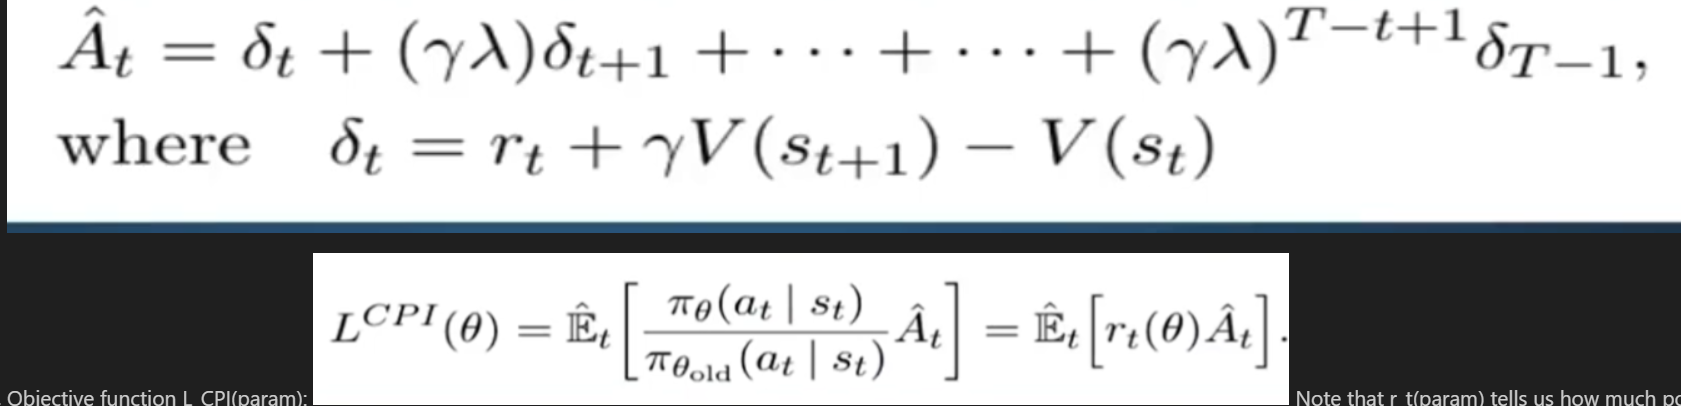

In [12]:
env = gym.make("CartPole-v0")
n_games = 200
N = 20
n_steps = 0
score_history = []
agent = Agent(n_actions = 2, input_dims = 4, gamma = 0.99, alpha = 0.0003, gae_lambda=0.9, policy_clip=0.2)
# observation = env.reset()[0]
# env.action_space
for i in range(n_games):
    observation = env.reset()[0]
    done = False
    score = 0
    iter = 0
    while not done:
        action, prob, vals = agent.choose_action(observation)
        next_state, reward, done, truncated, info = env.step(action)
        score += reward
        n_steps += 1
        agent.remember(observation, action, prob, vals, reward, done) 
        #We store state, action... up to 20, 40, 60, and then learn at each milestone
        if n_steps % N == 0:
            agent.learn()
            iter += 1
        observation = next_state
    score_history.append(score)
    if len(score_history) >= 100:
        average_score = np.mean(score_history[-100:])
    else:
        average_score = np.mean(score_history)
    print(f"Game {i}\tScore: {score}\tAverage Score is {average_score}")

C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Game 0	Score: 22.0	Average Score is 22.0
Game 1	Score: 16.0	Average Score is 19.0
Game 2	Score: 26.0	Average Score is 21.333333333333332
Game 3	Score: 26.0	Average Score is 22.5
Game 4	Score: 39.0	Average Score is 25.8
Game 5	Score: 30.0	Average Score is 26.5
Game 6	Score: 16.0	Average Score is 25.0
Game 7	Score: 23.0	Average Score is 24.75
Game 8	Score: 44.0	Average Score is 26.88888888888889
Game 9	Score: 23.0	Average Score is 26.5
Game 10	Score: 34.0	Average Score is 27.181818181818183
Game 11	Score: 28.0	Average Score is 27.25
Game 12	Score: 68.0	Average Score is 30.384615384615383
Game 13	Score: 86.0	Average Score is 34.357142857142854
Game 14	Score: 47.0	Average Score is 35.2
Game 15	Score: 51.0	Average Score is 36.1875
Game 16	Score: 83.0	Average Score is 38.94117647058823
Game 17	Score: 30.0	Average Score is 38.44444444444444
Game 18	Score: 99.0	Average Score is 41.63157894736842
Game 19	Score: 81.0	Average Score is 43.6
Game 20	Score: 85.0	Average Score is 45.57142857142857
Ga

In [7]:
env = gym.make("CartPole-v0")
observation = env.reset()[0]
agent = Agent(n_actions = 4, input_dims = 4, gamma = 0.8, alpha = 0.8, gae_lambda=None, policy_clip=None)
[observation]

C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


[array([ 0.02300653, -0.04404167,  0.04509454, -0.01258893], dtype=float32)]

In [8]:
b_s = 64
gamma = 0.8
gae_lambda = 0.8
state_dims = 4
state_arr = np.zeros((b_s, state_dims))
action_arr = old_probs_arr = vals_arr = reward_arr = done_arr = np.zeros(b_s)
batches = b_s
advantages = np.zeros(len(reward_arr), dtype = np.float32) #(b_s, )
for i in range(b_s - 1): #calculate all advantage from current b_s
    for j in range(i, b_s - 1):
        delta_t = reward_arr[j] + gamma * vals_arr[j+1]*(1-int(done_arr[j])) - vals_arr[j]
        advantages[i] += delta_t  * ((gamma * gae_lambda)**j)
advantages = t.tensor(advantages) #Now we calculate an array of advantages (reward_arr, )
advantages

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [9]:
import torch as t
x = t.tensor([0.8, 0.1, 0.1])
y = D.Categorical(x)
z = t.tensor([0, 2])
y.log_prob(z)

tensor([-0.2231, -2.3026])

In [10]:
np.zeros(5).shape

(5,)